# Quantum Computing Assignment

## Task 1

### Mathematical motivation

A matrix $A$'s, transformation can be represented by eigenvalues $\lambda_i$, the scale of its distortion, and their corresponding eigenvectors $|\psi_i\rangle$, the orientation of that distortion. 
$$
A|\psi\rangle = \lambda_i|\psi_i\rangle
$$
Finding the minimum eigenvalue $\lambda_{min}$ of a matrix is useful in many problems, such as in chemistry where the Hamiltonians, or energy dynamics, of a system can be represented by matrices and the minimum eigenvalue represents the ground state (minimum energy) $\lambda_{gs}$ of the system.

These Hamiltonians $H$ are real energy observables where 
$$
|\psi_t\rangle = U(t)|\psi_0\rangle 
$$
and $U(t)=e^{-itH}$ is a matrix exponential with some important properties
1. $H$ has real eigenvalues justifying its use to represent the Hamiltonian observables ${^1}$
2. $U$ is unitary with phases $e^{i\theta}$ as eigenvalues ${^2}$
3. The expected value (or probability) of the Hamiltonian $H$ on a state $|\psi\rangle$ is given by $\langle H\rangle_{\psi}=\langle\psi|H|\psi\rangle$ ${^3}$

### Approaches to finding the minimum eigenvalue

One approach is to calculate the $e^{i\theta}$ eigenvalue directly with Quantum Phase Estimation (QPE) which involves using phase kickback to write the phase of $U$ in the Fourier basis and taking the inverse of the Quantum Fourier Transform (QFT) to get back something measurable. However, this requires circuit depths exceeding the hardware available in the Noisy intermediate-scale quantum (NISQ) era.

Another alternative is to use Variational Quantum Eigensolvers (VQE) where we select an initial state (or ansatz) $|\psi\rangle$ to minimize the expected value of the Hamiltonian $\langle H\rangle_\psi$, giving us an upper bound on the minimum eigenvalue $\lambda_{min}$. To choose the ansatz some approaches such as Unitary Coupled Cluster (UCC) explore only a subspace of possible states, exploiting domain-specific quantum chemistry knowledge. However the problem, with these approaches is they they can be hard to compile and optimize for current quantum computers.

The approach explored in the paper is to use VQE but with an ansatz chosen to explore the whole space of states (negating the need for chemistry knowledge) and optimized to be run on quantum hardware.

### Implementation steps
1. Choose ansatz e.g. Hartree Fock State or vacuum state $|0\rangle$
2. Choose variational form UCCSD
3. Choose parameter optimization e.g. gradient descent, SPSA, COBYLA

### Mathematical Appendix

1. $H$ Hamiltonian is hermitian which means that it is equal to its conjugate transpose $H=H^\dagger$. By the spectral theorem $H$ has real eigenvalues justifying its use to represent the Hamiltonian observables.
2. $U$ is unitary which means that its inverse is equal to its conjugate transpose $U^{-1}=U^\dagger$. We prove this using the fact that $H$ is hermitian so that $U^\dagger U = (e^{-itH})^{\dagger} e^{-itH}= e^{itH^\dagger}e^{-itH}=e^{itH}e^{-itH} = I$. Furthermore, the matrix exponential $U$ of $H$ is still a matrix by expansion of exponential as Taylor series but with the property that $U|\psi\rangle = e^{i\theta}|\psi\rangle$ i.e. unitary matrices have phases $e^{i\theta}$ as eigenvalues
3. The expected value then provides an upper bound for the minimum eigenvalue $\lambda_{min}\leq \langle H\rangle_\psi=\langle\psi|H|\psi\rangle$ because $H$ can be written as the weighted sum of its eigenvectors $H = \sum_{i=1}^n \lambda_i|\psi_i\rangle\langle\psi_i|$ which when substituting in gives $\langle H\rangle_\psi = \sum_{i=1}^n \lambda_i|\langle\psi_i|\psi\rangle|^2$ where $|\langle\psi_i|\psi\rangle|^2\geq 0$ giving an upper bound 

## Task 2

### Imports

In [2]:
%matplotlib inline
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from typing import Optional, List
import matplotlib.pyplot as plt
from math import pi

### Ansatz utility functions

In [3]:
# copied from lecture notes
def make_params(fst: int, snd: Optional[int] = None, label: str = "θ") -> List[Parameter]:
    start = 0 if snd is None else fst
    end = fst if snd is None else snd
    assert end >= start
    return [Parameter(f"{label}[{idx}]") for idx in range(start, end)]

We implement the arbitrary single-qubit euler rotations as a combination of $Z$ and $X$ gates given by 
$$
U^{q,i}(\underline{\theta})=Z^q_{\theta_{1}^{q,i}}X^q_{\theta_{2}^{q,i}}Z^q_{\theta_{3}^{q,i}}
$$
where $q$ is the qubit and $i$ is the depth using `.rz` and `.rx` gates. Note that for $U^{q,0}(\underline{\theta})$ the first set of $Z$ rotations is not implemented because, as stated in the paper, these are irrelevant when all the qubits are initialized in their ground state $|0\rangle$

The entangler, as suggested in the assignment, uses parametric controlled x rotation `.cx` gates where we entangle with the same pattern as in Figure 1.d with control-target pairs `[2, 1], [4, 5], [2, 4], [1, 3], [6, 5]` (note that unlike the diagram in Qiskit we count from qubit 0 not qubit 1 so all the numbers are one less)

Text(0.5, 1.0, 'post rotations')

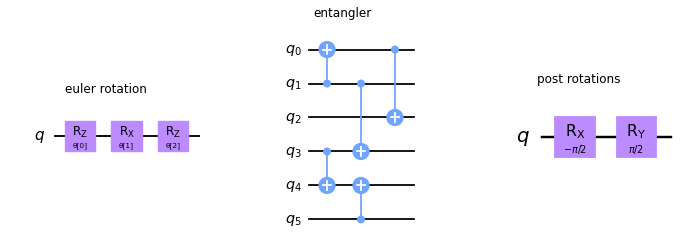

In [17]:
plt.figure(figsize=(12,4))
def euler_rotation(params, with_z_rot=True):
    euler_rotation = QuantumCircuit(1)
    if with_z_rot: # allow exclusion of first set of z rotations 
        euler_rotation.rz(params[0], 0)  
        euler_rotation.rx(params[1], 0)
        euler_rotation.rz(params[2], 0)
    else:
        euler_rotation.rx(params[0], 0)
        euler_rotation.rz(params[1], 0)
    return euler_rotation
euler_rotation(make_params(3)).draw("mpl", ax=plt.subplot(131));
plt.title("euler rotation")

def entangler():
    entangler = QuantumCircuit(6)
    entangler.cx([1, 3, 1, 0, 5], [0, 4, 3, 2, 4])
    return entangler
entangler().draw("mpl", ax=plt.subplot(132))
plt.title("entangler")

def post_rotations():
    post_rotations = QuantumCircuit(1)
    post_rotations.rx(-pi/2, 0)
    post_rotations.ry(pi/2, 0)
    return post_rotations
post_rotations().draw("mpl", ax=plt.subplot(133))
plt.title("post rotations")

We implement the general hardware efficient ansatz, with the option to change the depth of the circuit with an argument.

### Generic hardware efficient ansatz

We provide a flag in the `hardware_efficient_ansatz` function to `use_six_qubits` where we can either choose a circuit that matches the underlying hardware or a simplified circuit with just the used qubits. For example, the $H_2$ circuit is implemented as using qubits `1` and `3` (of qubits `0` to `5`), but for the purposes of our experiments it is easier to use a simplified two qubit architecture.

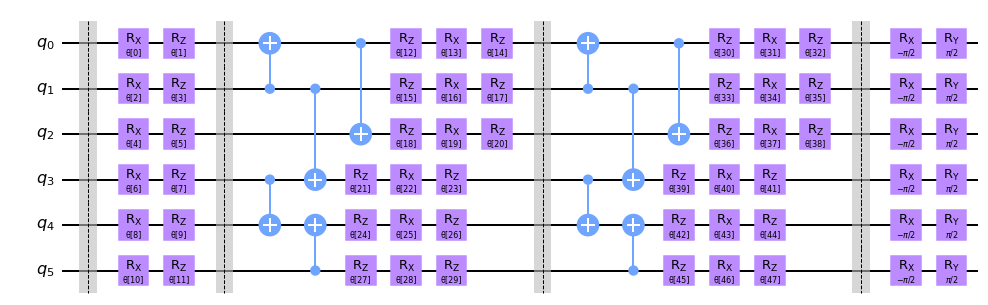

In [18]:
def hardware_efficient_ansatz(qubits, params, entangler, depth=1, use_six_qubits=False):
    num_qubits_used = len(qubits)
    num_qubits = num_qubits_used
    if use_six_qubits:
        num_qubits = 6
    num_gates_per_euler_rot = 3
    num_gates_first_euler_rot = 2
    assert len(params) == hardware_efficient_ansatz_num_params(
        num_qubits_used, depth, num_gates_per_euler_rot, num_gates_first_euler_rot), "Wrong number of parameters"
    he_ansatz = QuantumCircuit(num_qubits)

    # State preparation section: - all qubits are initialized to their ground 
    # state |0>
    he_ansatz.barrier()

    # Initial rotations sections: euler rotations skipping first z rotation
    for i, q in enumerate(qubits):
        params_start = i * num_gates_first_euler_rot
        params_stop = params_start + num_gates_first_euler_rot
        he_ansatz.compose(euler_rotation(params[params_start: params_stop], False), qubits=range(q, q+1), inplace=True)
    params_used_first_euler_rot = num_qubits_used * num_gates_first_euler_rot

    # Entangling section: of interleaved single-qubit rotations and entangling 
    # unitary operations
    for d in range(depth):
        he_ansatz.barrier()
        he_ansatz.compose(entangler, qubits=range(num_qubits), inplace=True)
        for i, q in enumerate(qubits):
            params_start = params_used_first_euler_rot + num_gates_per_euler_rot * (d * num_qubits_used + i)
            params_stop = params_start + num_gates_per_euler_rot
            he_ansatz.compose(euler_rotation(params[params_start: params_stop]), qubits=range(q, q+1), inplace=True)
    he_ansatz.barrier()

    # Post rotations section: 
    for q in qubits:
        he_ansatz.compose(post_rotations(), qubits=range(q, q+1), inplace=True)

    # Measurement section: 

    return he_ansatz

def hardware_efficient_ansatz_num_params(num_qubits, depth=1, num_gates_per_euler_rot=3, num_gates_first_euler_rot=2):
    # p = n(3d + 2)
    return num_qubits * (num_gates_per_euler_rot * depth + num_gates_first_euler_rot)

he_ansatz_num_qubits = 6
he_ansatz_qubits = range(he_ansatz_num_qubits)
he_ansatz_depth = 2
he_ansatz_num_params = hardware_efficient_ansatz_num_params(he_ansatz_num_qubits, he_ansatz_depth)
he_ansatz_params = make_params(he_ansatz_num_params)
hardware_efficient_ansatz(he_ansatz_qubits, he_ansatz_params, entangler(), he_ansatz_depth).draw("mpl")

### Implementation of 3 ansatzs

#### $H_2$ ansatz

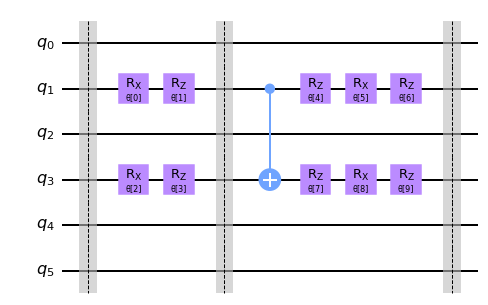

In [6]:
def h2_entangler_six_qubits():
    entangler = QuantumCircuit(6)
    entangler.cx([1], [3])
    return entangler

h2_ansatz_qubits_six_qubits = [1, 3]
h2_ansatz_num_params_six_qubits = hardware_efficient_ansatz_num_params(len(h2_ansatz_qubits_six_qubits))
h2_ansatz_params_six_qubits = make_params(h2_ansatz_num_params_six_qubits)
h2_ansatz_six_qubits = hardware_efficient_ansatz(
    h2_ansatz_qubits_six_qubits, h2_ansatz_params_six_qubits, h2_entangler_six_qubits(), use_six_qubits=True)
h2_ansatz_six_qubits.draw("mpl")

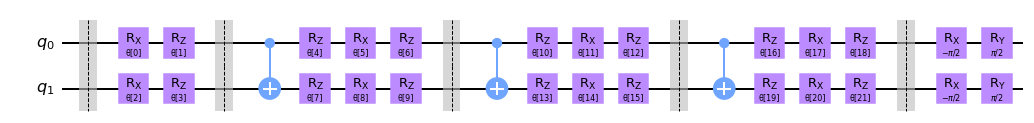

In [19]:
def h2_entangler():
    entangler = QuantumCircuit(2)
    entangler.cx([0], [1])
    return entangler

h2_ansatz_qubits = [0, 1]
h2_ansatz_num_params = hardware_efficient_ansatz_num_params(len(h2_ansatz_qubits), depth=3)
h2_ansatz_params = make_params(h2_ansatz_num_params)
h2_ansatz = hardware_efficient_ansatz(h2_ansatz_qubits, h2_ansatz_params, h2_entangler(), depth=3)
h2_ansatz.draw("mpl")

#### $LiH$ ansatz

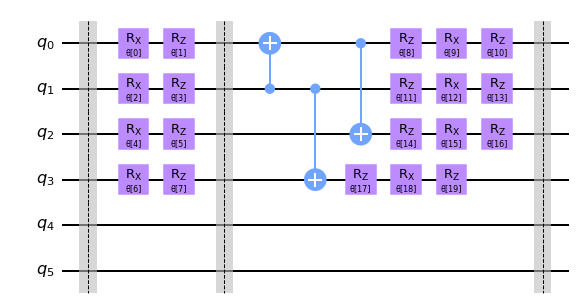

In [7]:
def lih_entangler_six_qubits():
    entangler = QuantumCircuit(6)
    entangler.cx([1, 1, 0], [0, 3, 2])
    return entangler

lih_ansatz_qubits_six_qubits = range(4)
lih_ansatz_num_params_six_qubits = hardware_efficient_ansatz_num_params(len(lih_ansatz_qubits_six_qubits))
lih_ansatz_params_six_qubits = make_params(lih_ansatz_num_params_six_qubits)
lih_ansatz_six_qubits = hardware_efficient_ansatz(
    lih_ansatz_qubits_six_qubits, lih_ansatz_params_six_qubits, lih_entangler_six_qubits(), use_six_qubits=True)
lih_ansatz_six_qubits.draw("mpl")

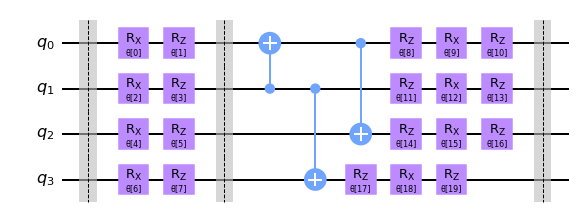

In [8]:
def lih_entangler():
    entangler = QuantumCircuit(4)
    entangler.cx([1, 1, 0], [0, 3, 2])
    return entangler

lih_ansatz_qubits = range(4)
lih_ansatz_num_params = hardware_efficient_ansatz_num_params(len(lih_ansatz_qubits))
lih_ansatz_params = make_params(lih_ansatz_num_params)
lih_ansatz = hardware_efficient_ansatz(lih_ansatz_qubits, lih_ansatz_params, lih_entangler())
lih_ansatz.draw("mpl")

#### $BeH_2$ ansatz

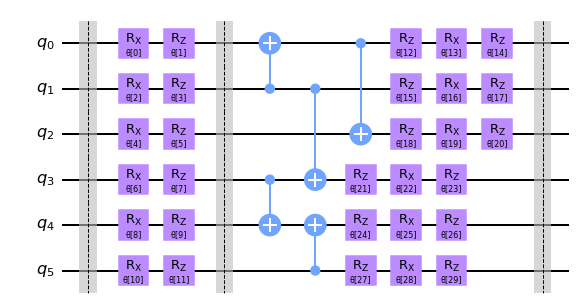

In [9]:
def beh2_entangler():
    entangler = QuantumCircuit(6)
    entangler.cx([1, 3, 1, 0, 5], [0, 4, 3, 2, 4])
    return entangler

beh2_ansatz_qubits = range(6)
beh2_ansatz_num_params = hardware_efficient_ansatz_num_params(len(beh2_ansatz_qubits))
beh2_ansatz_params = make_params(beh2_ansatz_num_params)
beh2_ansatz = hardware_efficient_ansatz(beh2_ansatz_qubits, beh2_ansatz_params, beh2_entangler())
beh2_ansatz.draw("mpl")

## Task 3

### Imports

In [9]:
from typing import Mapping
from qiskit import ClassicalRegister, execute
from qiskit.algorithms.optimizers import COBYLA
from qiskit.providers.aer import AerSimulator
from qiskit.result import marginal_counts
import numpy as np

### Molecular Hamiltonians & Paulis

The `molecular_hamiltonians` function, adapted from the code snippet in the assignment notes, extracts a dictionary of pauli strings to bond distances. 

It also returns a dictionary of paulis to required paulis. This is calculated as one required pauli per group rather than by the z replace i rule in the class notes. As can be seen in the $H_2$ and $LiH$ molecular hamiltonians sections - this makes no difference in the number of required paulis, keeping them at 2 and 25 respectively. However, we can see in the $BeH_2$ section that rather than 62 paulis we only need 44. It is crucial to note, however, that sometimes the required pauli string we calculate is not actually one of the paulis we require. For example, group 36 of $BeH_2$ is 
```
ZXXYYI
0.010336
ZXXIYY
0.010600
```
but the required pauli we calculate to cover both of them by marginalisation is actually `YYYXZZ` (where we have reversed the order). Therefore in order to marginalise properly we need to maintain a dictionary from pauli string to get the required `full_counts`

In [10]:
def molecular_hamiltonians(groups, exp_num_groups, exp_num_pauli_terms):
    mol_ham = {}
    req_paulis = {}
    assert len(groups) == exp_num_groups, "incorrect number of groups"
    assert len(set(groups)) == exp_num_groups, "repeated groups"
    for g in groups:
        a = [x for x in g.split("\n") if x]
        paulis = list(g[::-1] for g in a[::2]) # turn generator into list to use in req_paulis & mol_ham
        req_paulis.update(req_paulis.fromkeys(paulis, req_paulis_by_group(paulis)))
        bond_dists = (float(x) for x in a[1::2])
        mol_ham.update(zip(paulis, bond_dists))
    assert len(mol_ham) == exp_num_pauli_terms, "incorrect number of pauli terms"
    assert len(set(req_paulis.values())) == exp_num_groups, "incorrect number of required paulis"
    return mol_ham, req_paulis

def req_paulis_by_group(paulis):
    req_pauli = []
    for pauli in paulis:
        if req_pauli == []:
            req_pauli = list(pauli) # turn immutable string into array of characters
        else:
            for i in range(len(req_pauli)):
                if req_pauli[i] == 'I' and pauli[i] != 'I':
                    req_pauli[i] = pauli[i]
    # validation
    for pauli in paulis:
        for i in range(len(req_pauli)):
            # i.e. there should never be a contradiction where p[i] = X and req_pauli[i] = Z etc.
            assert req_pauli[i] == pauli[i] or pauli[i] == 'I' 
    return ''.join(req_pauli)

def req_paulis_z_replace_i(num_qubits: int, obs: Mapping[str, float]):
    assert all(len(pauli) == num_qubits for pauli in obs)
    # tomography of required Paulis
    required_paulis_list = sorted({pauli.replace("I", "Z") for pauli in obs if not all(p == "I" for p in pauli)})
    return required_paulis_list

#### $H_2$ molecular hamiltonians & paulis

In [20]:
h2_groups = [
# group 1
"""ZZ
0.011280
ZI
0.397936
IZ
0.397936""",
# group 2
"""XX
    0.180931"""
]
h2_ham, h2_req_paulis = molecular_hamiltonians(h2_groups, 2, 4)

h2_req_paulis_z_replace_i_list = req_paulis_z_replace_i(2, h2_ham)
print(f"req_paulis_z_replace_i number of paulis : {h2_req_paulis_z_replace_i_list} " + 
      f"len={len(h2_req_paulis_z_replace_i_list)}")
h2_req_paulis_by_group_list = list(set(h2_req_paulis.values()))
print(f"req_paulis_by_group number of paulis : {h2_req_paulis_by_group_list} " + 
      f"len={len(h2_req_paulis_by_group_list)}")


req_paulis_z_replace_i number of paulis : ['XX', 'ZZ'] len=2
req_paulis_by_group number of paulis : ['ZZ', 'XX'] len=2


#### $LiH$ molecular hamiltonians & paulis

In [27]:
lih_groups = [
# group 1
"""ZIII
-0.096022
ZZII
-0.206128
IZII
0.364746
IIZI
0.096022
IIZZ
-0.206128
IIIZ
-0.364746
ZIZI
-0.145438
ZIZZ
0.056040
ZIIZ
0.110811
ZZZI
-0.056040
ZZZZ
0.080334
ZZIZ
0.063673
IZZI
0.110811
IZZZ
-0.063673
IZIZ
-0.095216""",
# group 2
"""XZII
-0.012585
XIII
0.012585
IIXZ
0.012585
IIXI
0.012585
XZXZ
-0.002667
XZXI
-0.002667
XIXZ
0.002667
XIXI
0.002667
XZIZ
0.007265
XIIZ
-0.007265
IZXZ
0.007265
IZXI
0.007265""",
# group 3
"""XXII
-0.029640
IXII
0.002792
IIXX
-0.029640
IIIX
0.002792
XIXX
-0.008195
XIIX
-0.001271
XXXI
-0.008195
XXXX
0.028926
XXIX
0.007499
IXXI
-0.001271
IXXX
0.007499
IXIX
0.009327""",
# group 4
"""YYII
0.029640
IIYY
0.029640
YYYY
0.028926""",
# group 5
"""ZXII
0.002792
IIZX
-0.002792
ZIZX
-0.016781
ZIIX
0.016781
ZXZI
-0.016781
IXZI
-0.016781
ZXZX
-0.009327
ZXIX
0.009327
IXZX
-0.009327""",
# group 6
"""ZIXZ
-0.011962
ZIXI
-0.011962
ZZXZ
0.000247
ZZXI
0.000247""",
# group 7 
"""ZIXX
0.039155
ZZXX
-0.002895
ZZIX
-0.009769
IZXX
-0.024280
IZIX
-0.008025""",
# group 8
"""ZIYY
-0.039155
ZZYY
0.002895
IZYY
0.024280""",
# group 9
"""XZZI
-0.011962
XIZI
0.011962
XZZZ
-0.000247
XIZZ
0.000247""",
# group 10
"""XZXX
0.008195
XZIX
0.001271""",
# group 11 
"""XZYY
-0.008195
XIYY
0.008195""",
# group 12
"""XZZX
-0.001271
XIZX
0.001271
IZZX
0.008025""",
# group 13
"""XXZI
-0.039155
XXZZ
-0.002895
XXIZ
0.024280
IXZZ
-0.009769
IXIZ
0.008025""",
# group 14 
"""YYZI
0.039155
YYZZ
0.002895
YYIZ
-0.024280""",
# group 15
"""XXXZ
-0.008195
IXXZ
-0.001271""",
# group 16
"""YYXZ
0.008195
YYXI
0.008195""",
# group 17 
"""XXYY
-0.028926
IXYY
-0.007499""",
# group 18
"""YYXX
-0.028926
YYIX
-0.007499""",
# group 19
"""XXZX
-0.007499""",
# group 20
"""YYZX
0.007499""",
# group 21
"""ZZZX
0.009769""",
# group 22
"""ZXXZ
-0.001271
ZXXI
-0.001271
ZXIZ
0.008025""",
# group 23
"""ZXXX
0.007499""",
# group 24
"""ZXYY
-0.007499""",
# group 25
"""ZXZZ
-0.009769""",
]
lih_ham, lih_req_paulis = molecular_hamiltonians(lih_groups, 25, 99)

lih_req_paulis_z_replace_i_list = req_paulis_z_replace_i(4, lih_ham)
print(f"req_paulis_z_replace_i number of paulis : {lih_req_paulis_z_replace_i_list} " + 
      f"len={len(lih_req_paulis_z_replace_i_list)}")
lih_req_paulis_by_group_list = list(set(lih_req_paulis.values()))
print(f"req_paulis_by_group number of paulis : {lih_req_paulis_by_group_list} " + 
      f"len={len(lih_req_paulis_by_group_list)}")

req_paulis_z_replace_i number of paulis : ['XXXX', 'XXXZ', 'XXYY', 'XXZX', 'XXZZ', 'XZXX', 'XZXZ', 'XZYY', 'XZZX', 'XZZZ', 'YYXX', 'YYXZ', 'YYYY', 'YYZX', 'YYZZ', 'ZXXX', 'ZXXZ', 'ZXYY', 'ZXZX', 'ZXZZ', 'ZZXX', 'ZZXZ', 'ZZYY', 'ZZZX', 'ZZZZ'] len=25
req_paulis_by_group number of paulis : ['ZXZZ', 'XZXX', 'ZZYY', 'XXYY', 'YYZX', 'ZZXZ', 'XZYY', 'ZZZZ', 'XXZZ', 'ZXZX', 'YYYY', 'ZXXZ', 'ZZXX', 'XZZZ', 'ZXXX', 'ZXYY', 'YYXX', 'YYXZ', 'XZXZ', 'YYZZ', 'ZZZX', 'XXZX', 'XXXX', 'XXXZ', 'XZZX'] len=25


#### $BeH_2$ molecular hamiltonians & paulis

In [15]:
beh2_groups = [
# group 1
"""ZIIIII
-0.143021
ZZIIII
0.104962
IZZIII
0.038195
IIZIII
-0.325651
IIIZII
-0.143021
IIIZZI
0.104962
IIIIZZ
0.038195
IIIIIZ
-0.325651
IZIIII
0.172191
ZZZIII
0.174763
ZIZIII
0.136055
ZIIZII
0.116134
ZIIZZI
0.094064
ZIIIZZ
0.099152
ZIIIIZ
0.123367
ZZIZII
0.094064
ZZIZZI
0.098003
ZZIIZZ
0.102525
ZZIIIZ
0.097795
IZZZII
0.099152
IZZZZI
0.102525
IZZIZZ
0.112045
IZZIIZ
0.105708
IIZZII
0.123367
IIZZZI
0.097795
IIZIZZ
0.105708
IIZIIZ
0.133557
IIIIZI
0.172191
IIIZZZ
0.174763
IIIZIZ
0.136055""",
# group 2
"""XZIIII
0.059110
XIIIII
-0.059110
IZXIII
0.161019
IIXIII
-0.161019
IIIXZI
0.059110
IIIXII
-0.059110
IIIIZX
0.161019
IIIIIX
-0.161019
XIXIII
-0.038098
XZXIII
-0.003300
XZIXZI
0.013745
XZIXII
-0.013745
XIIXZI
-0.013745
XIIXII
0.013745
XZIIZX
0.011986
XZIIIX
-0.011986
XIIIZX
-0.011986
XIIIIX
0.011986
IZXXZI
0.011986
IZXXII
-0.011986
IIXXZI
-0.011986
IIXXII
0.011986
IZXIZX
0.013836
IZXIIX
-0.013836
IIXIZX
-0.013836
IIXIIX
0.013836
IIIXIX
-0.038098
IIIXZX
-0.003300""",
# group 3
"""ZZXIII
-0.002246
ZIXIII
0.002246
ZIIXZI
0.014815
ZIIXII
-0.014815
ZIIIZX
0.009922
ZIIIIX
-0.009922
ZZIXZI
-0.002038
ZZIXII
0.002038
ZZIIZX
-0.007016
ZZIIIX
0.007016""",
# group 4
"""XIZIII
-0.006154
XZZIII
0.006154
XZIZII
0.014815
XIIZII
-0.014815
XZIZZI
-0.002038
XIIZZI
0.002038
XZIIZZ
0.001124
XIIIZZ
-0.001124
XZIIIZ
0.017678
XIIIIZ
-0.017678""",
# group 5
"""YIYIII
-0.041398
YYIXXZ
0.011583
YYIIXI
-0.011094
IYYXXZ
0.010336
IYYIXI
-0.005725
IIIXIZ
-0.006154""",
# group 6
"""XXZXXZ
0.011583
XXZIXI
-0.011094
IXIXXZ
-0.011094
IXIIXI
0.026631
IIZXII
-0.017678""",
# group 7
"""XXZYYI
0.011583
XXZIYY
0.010336
IXIYYI
-0.011094
IXIIYY
-0.005725
IIIYIY
-0.041398""",
# group 8
"""YYIYYI
0.011583
YYIIYY
0.010336
IYYYYI
0.010336
IYYIYY
0.010600""",
# group 9
"""XXZXXX
0.024909
IXIXXX
-0.031035
IIZIIX
-0.010064""",
# group 10
"""XXZYXY
0.024909
IXIYXY
-0.031035""",
# group 11
"""YYIXXX
0.024909
IYYXXX
0.021494""",
# group 12
"""YYIYXY
0.024909
IYYYXY
0.021494""",
# group 13
"""XXZZXZ
0.011094
IXIZXZ
-0.026631""",
# group 14
"""YYIZXZ
0.011094
IYYZXZ
0.005725""",
# group 15
"""XXZZXX
0.010336
IXIZXX
-0.005725
IIIZIX
0.002246""",
# group 16
"""YYIZXX
0.010336
IYYZXX
0.010600""",
# group 17
"""XXXXXZ
0.024909
XXXIXI
-0.031035
IIXIIZ
-0.010064""",
# group 18
"""XXXYYI
0.024909
XXXIYY
0.021494""",
# group 19
"""YXYXXZ
0.024909
YXYIXI
-0.031035""",
# group 20
"""YXYYYI
0.024909
YXYIYY
0.021494""",
# group 21
"""XXXXXX
0.063207""",
# group 22
"""XXXYXY
0.063207""",
# group 23
"""YXYXXX
0.063207""",
# group 24
"""YXYYXY
0.063207""",
# group 25
"""XXXZXZ
0.031035
IIXZII
-0.009922""",
# group 26
"""YXYZXZ
0.031035""",
# group 27
"""XXXZXX
0.021494""",
# group 28
"""YXYZXX
0.021494""",
# group 29
"""ZXZXXZ
0.011094
ZXZIXI
-0.026631""",
# group 30
"""ZXZYYI
0.011094
ZXZIYY
0.005725""",
# group 31
"""ZXZXXX
0.031035""",
# group 32
"""ZXZYXY
0.031035""",
# group 33
"""ZXZZXZ
0.026631""",
# group 34
"""ZXZZXX
0.005725
""",
# group 35
"""ZXXXXZ
0.010336
ZXXIXI
-0.005725""",
# group 36
"""ZXXYYI
0.010336
ZXXIYY
0.010600""",
# group 37
"""ZXXXXX
0.021494""",
# group 38
"""ZXXYXY
0.021494""",
# group 39
"""ZXXZXZ
0.005725""",
# group 40
"""ZXXZXX
0.010600""",
# group 41
"""IZZXZI
0.001124
IZZXII
-0.001124
IZZIZX
-0.007952
IZZIIX
0.007952
IIZXZI
0.017678
IIZIZX
0.010064""",
# group 42
"""IZXZII
0.009922
IZXZZI
-0.007016
IIXZZI
0.007016
IZXIZZ
-0.007952
IIXIZZ
0.007952
IZXIIZ
0.010064""",
# group 43
"""IIIZZX
-0.002246""",
# group 44
"""IIIXZZ
0.006154""",
]
beh2_ham, beh2_req_paulis = molecular_hamiltonians(beh2_groups, 44, 164)

beh2_req_paulis_z_replace_i_list = req_paulis_z_replace_i(6, beh2_ham)
print(f"req_paulis_z_replace_i number of paulis : {beh2_req_paulis_z_replace_i_list} " + 
      f"len={len(beh2_req_paulis_z_replace_i_list)}")
beh2_req_paulis_by_group_list = list(set(beh2_req_paulis.values()))
print(f"req_paulis_by_group number of paulis : {beh2_req_paulis_by_group_list} " + 
      f"len={len(beh2_req_paulis_by_group_list)}")

req_paulis_z_replace_i number of paulis : ['XXXXXX', 'XXXXXZ', 'XXXYXY', 'XXXYYZ', 'XXXZXX', 'XXXZXZ', 'XXXZYY', 'XXZXXX', 'XXZXXZ', 'XXZYXY', 'XXZYYZ', 'XXZZXX', 'XXZZXZ', 'XXZZYY', 'XZXZZZ', 'XZZXZZ', 'XZZZZX', 'XZZZZZ', 'YXYXXX', 'YXYXXZ', 'YXYYXY', 'YXYYYZ', 'YXYZXX', 'YXYZXZ', 'YXYZYY', 'YYZXXX', 'YYZXXZ', 'YYZYXY', 'YYZYYZ', 'YYZZXX', 'YYZZXZ', 'YYZZYY', 'YZYZZZ', 'ZXXXXX', 'ZXXXXZ', 'ZXXYXY', 'ZXXYYZ', 'ZXXZXX', 'ZXXZXZ', 'ZXXZYY', 'ZXZXXX', 'ZXZXXZ', 'ZXZYXY', 'ZXZYYZ', 'ZXZZXX', 'ZXZZXZ', 'ZXZZYY', 'ZYYXXX', 'ZYYXXZ', 'ZYYYXY', 'ZYYYYZ', 'ZYYZXX', 'ZYYZXZ', 'ZYYZYY', 'ZZXXZZ', 'ZZXZZX', 'ZZXZZZ', 'ZZZXZX', 'ZZZXZZ', 'ZZZYZY', 'ZZZZZX', 'ZZZZZZ'] len=62
req_paulis_by_group number of paulis : ['XXXZXX', 'XZXZZI', 'YXYXXZ', 'ZXXYXY', 'ZZXIII', 'XZXXZZ', 'XZXXZX', 'XXZYYY', 'XXZZXX', 'ZXZZXZ', 'XXZXXZ', 'XXXYXY', 'ZZZXZI', 'ZZZZZX', 'XXXXXZ', 'XXXYYY', 'XXXZXZ', 'ZXXXXZ', 'YXYYXY', 'ZXZZXX', 'YYYZXX', 'YYYYXY', 'ZXXZXZ', 'YXYZXZ', 'ZXXYYY', 'YXYYYY', 'ZZZZZZ', 'ZXXZXX', 'XXZYXY', 

### Measurement & marginalisation

In [21]:
def assign_params(ansatz, params):
    assert len(ansatz.parameters) == len(params)
    state_prep = ansatz.assign_parameters(dict(zip(ansatz.parameters, params)))
    return state_prep

def req_tomography_circuits(state_prep: QuantumCircuit, required_paulis_list: List[str], r2l: bool = True):
    circ = state_prep.copy(); 
    circ.add_register(ClassicalRegister(state_prep.num_qubits))
    tomography_circuits = {pauli: circ.compose(pauli_meas(pauli, r2l=r2l)) for pauli in required_paulis_list}
    return tomography_circuits

def req_tomography_counts(tomography_circuits, **kwargs):
    batch = list(tomography_circuits.values())
    job = execute(batch, **kwargs)
    counts_list = job.result().get_counts()
    tomography_counts = dict(zip(tomography_circuits.keys(), counts_list))
    return tomography_counts

def pauli_meas(pauli: str, r2l: bool = True) -> QuantumCircuit:
    """
        Applies a Pauli measurement to each qubit, specified by a given Paulistring,
        with I indicating that the qubits should not be measured.
        The number of qubits is the length of `pauli`.
        The optional `r2l` kwarg determines whether the Paulistring is to be read right-to-left
        (default, consistent with Qiskit's own ordering) or left-to-right.
    """
    assert all(p in ("X", "Y", "Z", "I") for p in pauli)
    assert len(pauli) >= 1
    if r2l:
        # If paulistring is to be read right-to-left, invert it:
        pauli = pauli[::-1]
    n = len(pauli)
    # only qubits `q` with `pauli[q] != "I"` are measured:
    qubits_to_measure = [q for q in range(n) if pauli[q] != "I"]
    circ = QuantumCircuit(n, n)
    #Entry `B: g` is the gate to change from basis `B` to Z basis.
    basis_change_gate = {"X": "h", "Y": "sx", "Z": "i"}
    for q in qubits_to_measure:
        # for measured qubits, change basis from `paulis[q]` to Z basis:
        g = basis_change_gate[pauli[q]]
        getattr(circ, g)(q) # this is `circ.h(q)`, `circ.sx(q)` or `circ.i(q)`
    # measure qubits `q` in Z basis, store outcome at position `q` of classical reg:
    circ.measure(qubits_to_measure, qubits_to_measure)
    return circ

def marginalised_paulis_by_group(num_qubits: int, obs: Mapping[str, float], req_paulis, tomography_counts):
    # fill in remaining Paulis by marginalisation:
    for pauli in set(obs)-set(tomography_counts)-{"I"*num_qubits}:
        qubits_to_measure = [q for q in range(num_qubits) if pauli[num_qubits-1-q] != "I"]
        full_counts = tomography_counts[req_paulis[pauli]] 
        tomography_counts[pauli] = marginal_counts(full_counts, qubits_to_measure)
    return tomography_counts

def marginalised_paulis_z_replace_i(num_qubits: int, obs: Mapping[str, float], tomography_counts):
    # fill in remaining Paulis by marginalisation:
    for pauli in set(obs)-set(tomography_counts)-{"I"*num_qubits}:
        qubits_to_measure = [q for q in range(num_qubits) if pauli[num_qubits-1-q] != "I"]
        full_counts = tomography_counts[pauli.replace("I", "Z")] 
        tomography_counts[pauli] = marginal_counts(full_counts, qubits_to_measure)
    return tomography_counts

#### $H_2$ marginalisation

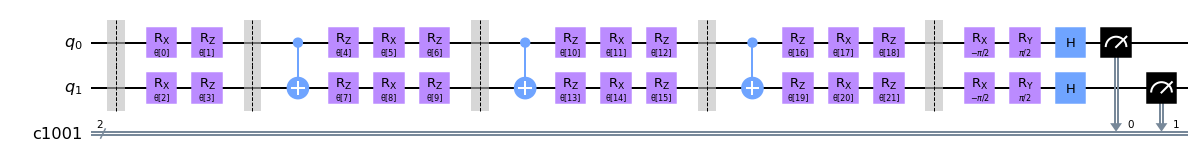

In [22]:
h2_init_param_vals = np.linspace(0, pi, h2_ansatz_num_params)
h2_ansatz_prep = assign_params(h2_ansatz, h2_init_param_vals)
h2_by_group_tomography_circuits = req_tomography_circuits(h2_ansatz, h2_req_paulis_by_group_list)
h2_by_group_tomography_circuits.get('XX').draw("mpl")
# h2_by_group_tomography_counts = req_tomography_counts(h2_by_group_tomography_circuits, backend=AerSimulator())

#### $LiH$ marginalisation

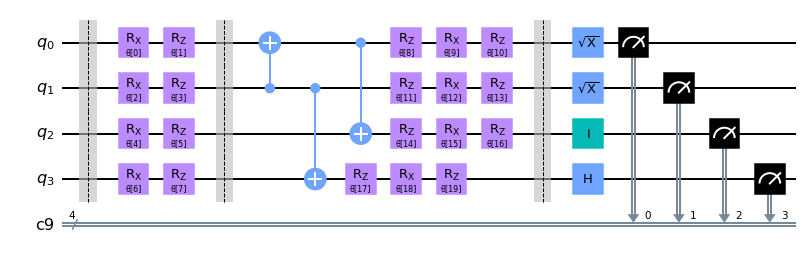

In [30]:
lih_ansatz_prep = assign_params(lih_ansatz, lih_ansatz_params)
lih_by_group_tomography_circuits = req_tomography_circuits(lih_ansatz, lih_req_paulis_by_group_list)
lih_by_group_tomography_circuits.get('XZYY').draw("mpl")

#### $BeH_2$ marginalisation

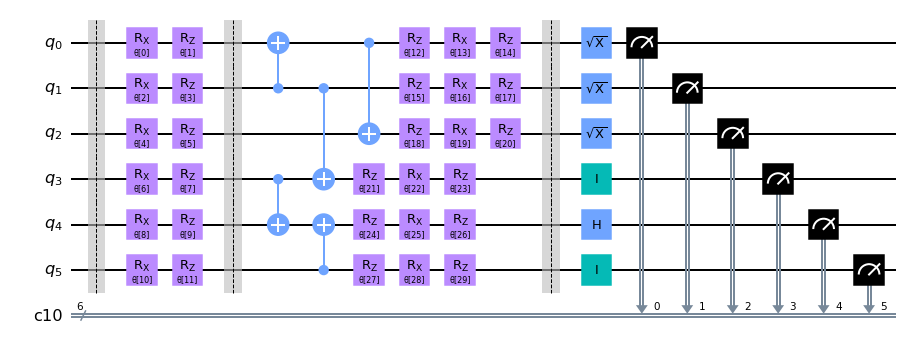

In [31]:
beh2_ansatz_prep = assign_params(beh2_ansatz, beh2_ansatz_params)
beh2_by_group_tomography_circuits = req_tomography_circuits(beh2_ansatz, beh2_req_paulis_by_group_list)
beh2_by_group_tomography_circuits.get('ZXZYYY').draw("mpl")

### Objective function & measurement

In [24]:
def make_obj_fun(ansatz, obs, required_paulis, qubits, simulator):
    hist = {"obj_val": [], "param_vals": []}
    def obj_fun(param_vals):
        state_prep = assign_params(ansatz, param_vals)
        tomography_circuits = req_tomography_circuits(state_prep, list(set(required_paulis.values())))
        tomography_counts = req_tomography_counts(tomography_circuits, backend=simulator)
        tomography_counts_marginalised = marginalised_paulis_by_group(ansatz.num_qubits, obs, required_paulis, tomography_counts)
        obj_val = expected_values(len(qubits), obs, tomography_counts_marginalised)
        hist["obj_val"].append(obj_val)
        hist["param_vals"].append(param_vals)
        return obj_val
    return obj_fun, hist

def expected_values(used_qubits, obs: Mapping[str, float], tomography_counts_marginalised):
    # compute expectation values:
    expvals = {"I"*used_qubits: 1.0} | {
        pauli: expval(counts) for pauli, counts in tomography_counts_marginalised.items()
    }
    return sum(obs_val*expvals[pauli] for pauli, obs_val in obs.items())

def expval(counts: Mapping[str, float]) -> float:
    """
        Computes the expectation value from a counts dictionary.
    """
    shots = sum(counts.values())
    p0 = sum(c/shots for b, c in counts.items() # probability = counts/shots
             if b.count("1")%2 == 0) # even bitsum
    p1 = sum(c/shots for b, c in counts.items()
             if b.count("1")%2 == 1) # odd bitsum
    return p0-p1 # expval = probability of even bitsum - probability of odd bitsum


#### Experiment

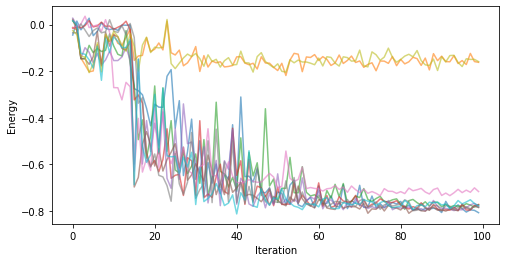

Observed minimum energies: [-0.813 -0.811 -0.808 -0.801 -0.8   -0.798 -0.793 -0.735 -0.219 -0.206]


In [26]:
rng = np.random.default_rng(seed=0)
nparams = len(h2_ansatz.parameters)
optimizer = COBYLA(maxiter=100)
min_energy_list = []; opt_param_vals_list = []
plt.figure(figsize=(8,4))
for _ in range(10):
    obj_fun, hist = make_obj_fun(h2_ansatz, h2_ham, h2_req_paulis, h2_ansatz_qubits, simulator=AerSimulator())
    opt, e, _ = optimizer.optimize(nparams, obj_fun, initial_point=rng.uniform(0.01, 0.01, size=nparams))
    min_energy_list.append(e); opt_param_vals_list.append(opt)
    plt.plot(hist["obj_val"], alpha=0.6)
plt.xlabel("Iteration"); plt.ylabel("Energy"); plt.show()
print("Observed minimum energies:", np.around(sorted(min_energy_list), 3))

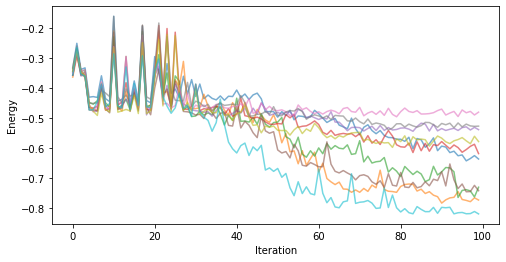

Observed minimum energies: [-0.82  -0.784 -0.765 -0.746 -0.643 -0.619 -0.598 -0.544 -0.54  -0.496]


In [64]:
rng = np.random.default_rng(seed=0)
nparams = len(lih_ansatz.parameters)
optimizer = COBYLA(maxiter=100)
min_energy_list = []; opt_param_vals_list = []
plt.figure(figsize=(8,4))
for _ in range(10):
    obj_fun, hist = make_obj_fun(lih_ansatz, lih_ham, lih_req_paulis, lih_ansatz_qubits, simulator=AerSimulator())
    opt, e, _ = optimizer.optimize(nparams, obj_fun, initial_point=rng.uniform(-0.1, 0.1, size=nparams))
    min_energy_list.append(e); opt_param_vals_list.append(opt)
    plt.plot(hist["obj_val"], alpha=0.6)
plt.xlabel("Iteration"); plt.ylabel("Energy"); plt.show()
print("Observed minimum energies:", np.around(sorted(min_energy_list), 3))

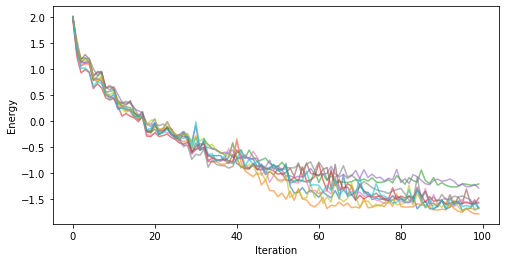

Observed minimum energies: [-1.787 -1.736 -1.725 -1.712 -1.694 -1.653 -1.649 -1.597 -1.289 -1.269]


In [62]:
rng = np.random.default_rng(seed=0)
nparams = len(beh2_ansatz.parameters)
optimizer = COBYLA(maxiter=100)
min_energy_list = []; opt_param_vals_list = []
plt.figure(figsize=(8,4))
for _ in range(10):
    obj_fun, hist = make_obj_fun(beh2_ansatz, beh2_ham, beh2_req_paulis, beh2_ansatz_qubits, simulator=AerSimulator())
    opt, e, _ = optimizer.optimize(nparams, obj_fun, initial_point=rng.uniform(-0.1, 0.1, size=nparams))
    min_energy_list.append(e); opt_param_vals_list.append(opt)
    plt.plot(hist["obj_val"], alpha=0.6)
plt.xlabel("Iteration"); plt.ylabel("Energy"); plt.show()
print("Observed minimum energies:", np.around(sorted(min_energy_list), 3))